In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from utils import maxpool2d, neighbors, my_saddle,my_saddle_2

In [2]:
img = fits.getdata("C:\\Users\\ricca\\Documents\\PyProjects\\TopoDenoising\\data\\f444w_finalV4.onlyPSF.fits")

img = img[0:40,0:40].astype(np.float32)

In [3]:
#img = np.load('dataset/1.npy')

img -= img.min()
img /= img.max()

# 1. Calcolo delle zone connesse
In questa sezione vengono calcolate le componenti connesse con i massimi locali.
Attraverso un'operazione di (arg)maxpool viene calcolato per ogni pixel, l'indice del massimo più vicino.
Vengono iterate le posizioni della mappa fino alla convergenza.

**TODO**: si può fare più rapidamente senza maxpool?

In [4]:
H, W = img.shape
p, m = maxpool2d(img, kernel_size=3, stride=1, padding=1, return_indices=True)
del p

img = img.flatten()
m_temp = m.flatten()
m = m_temp[m_temp]
while not np.array_equal(m_temp, m):
    m_temp = m
    m = m_temp[m_temp]
del m_temp

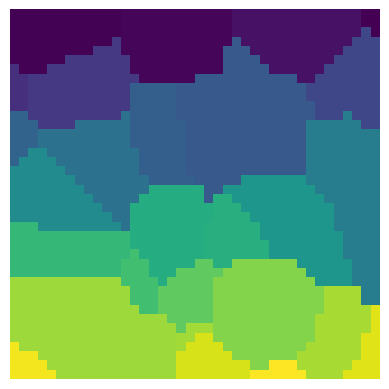

In [5]:
plt.imshow(m.reshape(H,W))
plt.axis('off')
plt.show()

# 2. Indicizzazione delle componenti
Le zone vengono indicizzate dalla più piccola alla più grande, rispetto al valore del centro relativo.

**TODO**: eliminare, forse inutile

In [6]:
pbirth = np.unique(m)
birth = img[pbirth]
idxs = np.argsort(birth)
pbirth = pbirth[idxs]

In [7]:
dict_replace = {pbirth[i]: i+1 for i in range(birth.size)}
p_idxs = np.sort(idxs + 1)

def replace(element):
    return dict_replace.get(element, element)
vreplace = np.vectorize(replace)
new_m = vreplace(m)

del birth, idxs, dict_replace, vreplace

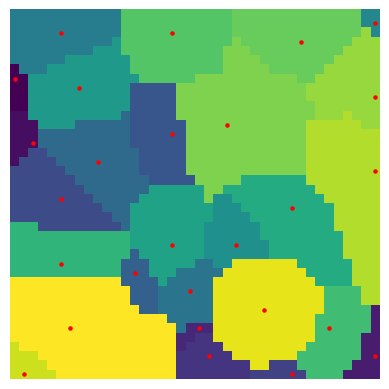

In [8]:
plt.imshow(new_m.reshape(H,W))
plt.scatter(pbirth % W, pbirth // W, 5, 'r')
plt.axis('off')
plt.show()

# 3. Individuazione dei bordi

Vengono individuate le zone di confine: la parte interna è invariante rispetto le operazioni di maxpool o -maxpool.

**TODO**: si potrebbe rimuovere il maxpool trovando le zone di confine con un ciclo (?!)

In [9]:
p1 = maxpool2d(new_m.reshape(H, W), kernel_size=3, stride=1, padding=1, return_indices=False).flatten()
p2 = -maxpool2d(-new_m.reshape(H, W), kernel_size=3, stride=1, padding=1, return_indices=False).flatten()

borders_idxs = set(np.nonzero(p1 != p2)[0].tolist())

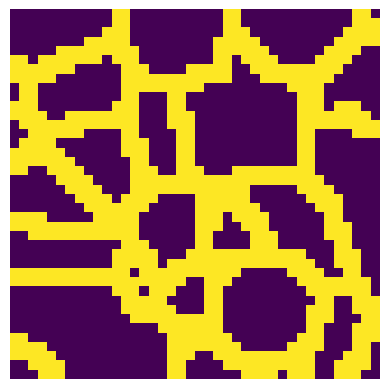

In [10]:
mask = np.zeros((H,W)).flatten()
mask[list(borders_idxs)] = 1
mask = mask.reshape(H,W)

plt.imshow(mask)
plt.axis('off')
plt.show()

# 4. Calcolo delle zone di "death"
I punti di death devono trovarsi sulle zone di confine; inoltre, per poter collegare due zone vicine devono essere punti di minimo relativo oppure punti di sella. Vengono quindi eliminati dalla mask precedente tutti i punti che non soddisfano queste condizioni

In [11]:
img_pad = np.pad(img.reshape(H,W), ((1, 1), (1, 1)), 'constant', constant_values=0)
m_pad = np.pad(new_m.reshape(H,W), ((1, 1), (1, 1)), 'constant', constant_values=0)
for x in borders_idxs.copy():
    w = x // W
    h = x % W
    if not my_saddle_2(img_pad[w:(w+3), h:(h+3)],m_pad[w:(w+3), h:(h+3)]):
        borders_idxs.discard(x)
for x in np.flip(pbirth):
    for y in neighbors(x, H, W):
        if new_m[y] != new_m[x]:
            borders_idxs.add(y)
    borders_idxs.discard(x)
del img_pad

borders_idxs = np.array(list(borders_idxs))
sort = np.flip(np.argsort(img[borders_idxs]))
borders_idxs = borders_idxs[sort]

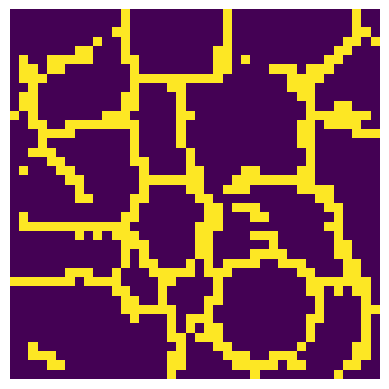

In [12]:
mask = np.zeros((H,W)).flatten()
mask[borders_idxs] = 1
mask = mask.reshape(H,W)

plt.imshow(mask)
plt.axis('off')
plt.show()

# 5. Calcolo dei punti di death

I possibili punti vengono ordinati in maniera decrescente. Se un punto confina con 2 zone, queste vengono unite. Il vettore changer contiene i cambi da effettuare sulla new_m. I cambi non vengono effettuati sulla maschera (per velocizzare l'algoritmo) ma solamente dopo aver estratto i punti confinanti.

In [24]:
pdeath = []
death_idxs = set()
changer = p_idxs.copy()
for x in borders_idxs:
    check = np.unique(changer[new_m[np.array(neighbors(x, H, W, mode=8))] -1])
    if len(check) >= 2 and (changer[new_m[x] -1] == check[0]):
        check = tuple([check[0], check[1]])
        if check not in death_idxs:
            death_idxs.add(check)
            changer[np.where(changer == check[0])[0]] = check[1]
            pdeath.append([check[0] -1, x])
del changer

pdeath = np.array(pdeath)
pdeath = pdeath[np.argsort(pdeath[:,0])][:,1]
pdeath = np.append(pdeath, np.argmin(img))

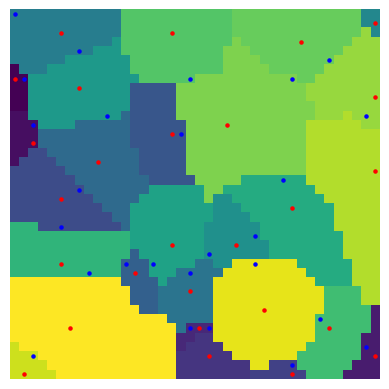

In [25]:
plt.imshow(new_m.reshape(H,W))
plt.scatter(pbirth % W, pbirth // W, 5, 'r')
plt.scatter(pdeath % W, pdeath // W, 5, 'b')
plt.axis('off')
plt.show()

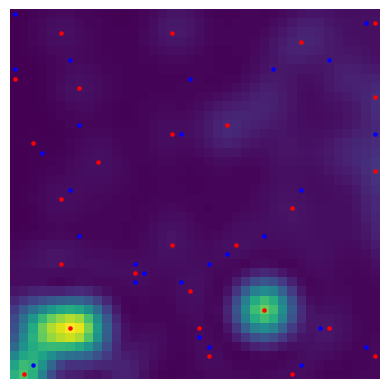

In [31]:
plt.imshow(img.reshape(H,W))
plt.scatter(pbirth % W, pbirth // W, 5, 'r')
plt.scatter(pdeath % W, pdeath // W, 5, 'b')
plt.axis('off')
plt.show()

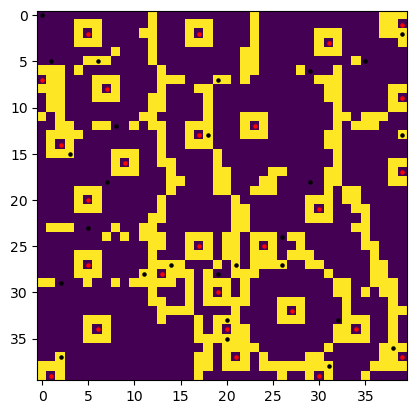

In [32]:
from ripser import lower_star_img

dgm_r = lower_star_img(-img.reshape(H,W))

idxs = np.arange(dgm_r.shape[0])
plt.imshow(mask.reshape(H,W))
X, Y = np.meshgrid(np.arange(img.reshape(H,W).shape[1]), np.arange(img.reshape(H,W).shape[0]))
X = X.flatten()
Y = Y.flatten()
for idx in idxs:
    bidx = np.argmin(np.abs(img.reshape(H,W) + dgm_r[idx, 0]))
    plt.scatter(X[bidx], Y[bidx], 5, 'r')

    bidx = np.argmin(np.abs(img.reshape(H,W) + dgm_r[idx, 1]))
    plt.scatter(X[bidx], Y[bidx], 5, 'k')

# 6. DGM

Viene generato il diagramma di persistenza collegando ogni punto di nascita con il suo relativo punto di morte

In [45]:
dgm = np.stack([img[pbirth],
                img[pdeath]], axis=1)
dgm

array([[0.00359187, 0.00336421],
       [0.00447047, 0.00429931],
       [0.02457216, 0.01938581],
       [0.02806389, 0.02798462],
       [0.03218047, 0.02789338],
       [0.03487052, 0.03238326],
       [0.03569667, 0.03276616],
       [0.0362221 , 0.03367873],
       [0.03908846, 0.03530197],
       [0.03953616, 0.02034189],
       [0.0409929 , 0.03663692],
       [0.04275582, 0.02763768],
       [0.04345812, 0.0409236 ],
       [0.04522298, 0.04087287],
       [0.04575273, 0.01878198],
       [0.05129204, 0.03348672],
       [0.0520598 , 0.03973366],
       [0.05454212, 0.03334879],
       [0.06165163, 0.05570013],
       [0.0680565 , 0.01233547],
       [0.10412147, 0.06963749],
       [0.1148931 , 0.06496853],
       [0.1303227 , 0.11575218],
       [0.15034337, 0.0316297 ],
       [0.71281755, 0.62900597],
       [0.774266  , 0.02981028],
       [1.        , 0.        ]], dtype=float32)

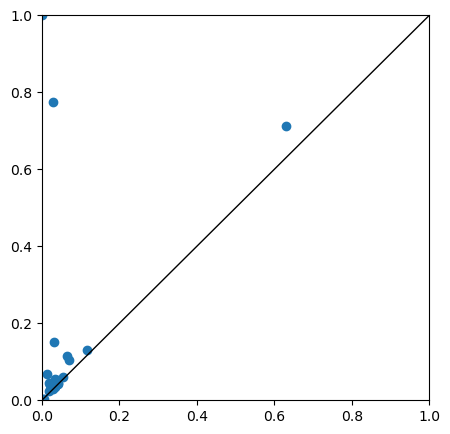

In [46]:
plt.figure(figsize=(5,5))
plt.scatter(dgm[:,1], dgm[:,0])
plt.plot([0, 1], [0, 1], 'k-', lw=1)
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

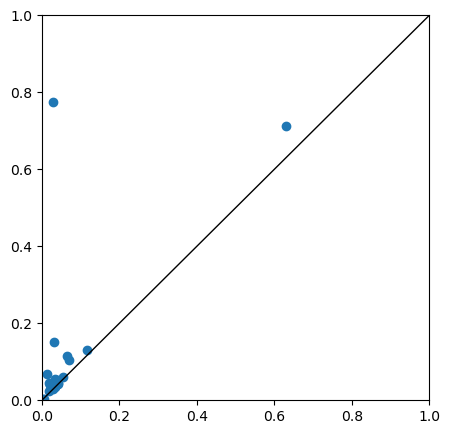

In [49]:
plt.figure(figsize=(5,5))
plt.scatter(-dgm_r[:,1], -dgm_r[:,0])
plt.plot([0, 1], [0, 1], 'k-', lw=1)
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

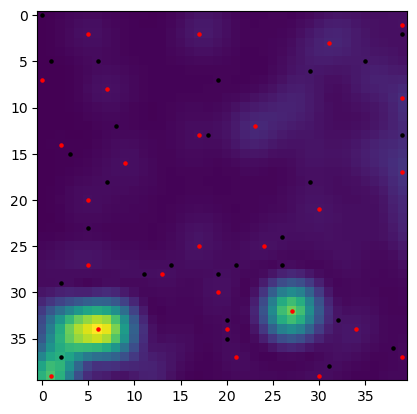

In [266]:
-dgm_r

array([[0.52937567, 0.49486426],
       [0.51076263, 0.4814553 ],
       [0.62824011, 0.40609908],
       [0.58093137, 0.2759763 ],
       [0.53223562, 0.19706908],
       [0.20702817, 0.18857712],
       [0.6722756 , 0.18125333],
       [0.0656876 , 0.06317271],
       [0.05277771, 0.04943267],
       [1.        ,       -inf]])